In [102]:
pip install surprise

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd
import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization
from collections import defaultdict             # A dictionary output that does not raise a key error
from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

In [104]:
# Import the dataset
df = pd.read_csv('kaputei_ratings.csv', header = None)  # There are no headers in the data file
df.columns = ['customer', 'product', 'rating']

In [105]:
# Print a few rows of the imported dataset
df.head()

,customer,product,rating
0,Carrefour - Comet,1000 Island Dressing 250gms,2
1,Carrefour - Comet,Barbecue Sauce 400 gms,5
2,Carrefour - Comet,Barbecue Sauce 700gm,1
3,Carrefour - Comet,Barbecue Sauce Honey 700g,2
4,Carrefour - Comet,Barbecue Sauce Smoke 700g,2


Exploratory Data Analysis

In [106]:
# Check the number of rows and columns and provide observations
rows, columns = df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  10049
No of columns:  3


In [107]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10049 entries, 0 to 10048
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   customer  10049 non-null  object
 1   product   10049 non-null  object
 2   rating    10049 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 235.7+ KB


In [108]:
# Check for missing values present and provide observations
df.isna().sum()

customer    0
product     0
rating      0
dtype: int64

In [109]:
# Summary statistics of 'rating' variable and provide observations
df.describe()

,rating
count,10049.000000
mean,3.591004
std,1.611409
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


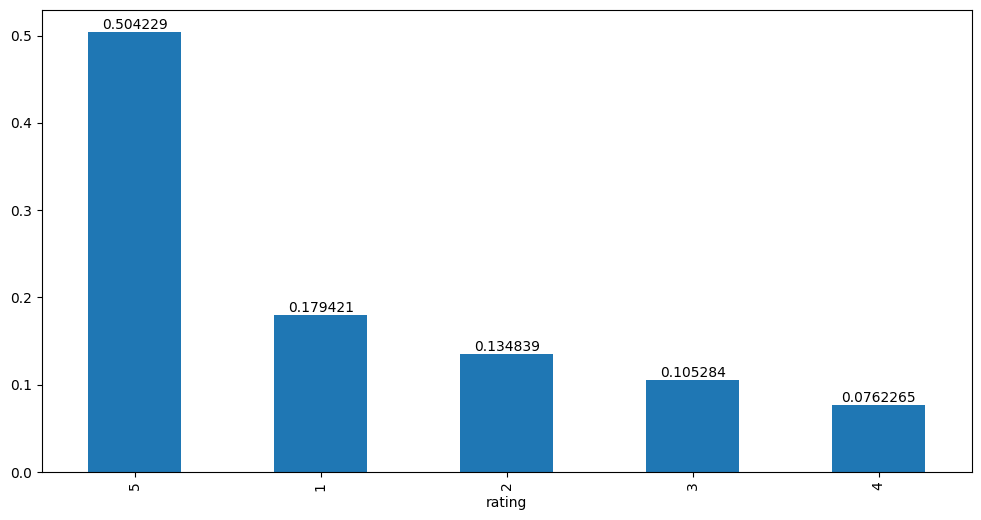

In [110]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

ax = df['rating'].value_counts(1).plot(kind = 'bar')

ax.bar_label(ax.containers[0])

plt.show()

In [111]:

print('The number of observations in the final data = ', len(df))
print('Number of unique USERS in Raw data = ', df['customer'].nunique())
print('Number of unique ITEMS in Raw data = ', df['product'].nunique())

The number of observations in the final data =  10049
Number of unique USERS in Raw data =  218
Number of unique ITEMS in Raw data =  149


In [112]:
# Top 10 users based on the number of ratings
most_rated = df.groupby('customer').size().sort_values(ascending = False)[:10]
most_rated

customer
Carrefour - Sarit         112
Carrefour - Nyali         110
Carrefour - Hub           109
Carrefour - Junction      109
Carrefour - Westgate      109
Carrefour - Galleria      108
Carrefour - Mega          108
Carrefour - Diani         107
Carrefour - TRM           107
Carrefour - Two Rivers    107
dtype: int64

Model 1: Rank Based Recommendation System

In [113]:
df.head(5000)

,customer,product,rating
0,Carrefour - Comet,1000 Island Dressing 250gms,2
1,Carrefour - Comet,Barbecue Sauce 400 gms,5
2,Carrefour - Comet,Barbecue Sauce 700gm,1
3,Carrefour - Comet,Barbecue Sauce Honey 700g,2
4,Carrefour - Comet,Barbecue Sauce Smoke 700g,2
...,...,...,...
4995,Naivas - Greenspan,Salsa Kachumbari 400 gms,5
4996,Naivas - Greenspan,Spaghetti Bolognaise 330g,3
4997,Naivas - Greenspan,Spaghetti Bolognaise 375g,5
4998,Naivas - Greenspan,Spaghetti Bolognaise Sauce 530g,5


In [114]:
# Calculate the average rating for each product
#average_rating = df_final[rating].mean()
average_rating = df.groupby('product')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df.groupby('product')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
product,,
Tomato Ketchup 400gms,4.747475,198
Tomato Ketchup 700gms,4.635870,184
Natural Honey 1 KG,4.590909,110
Barbecue Sauce 400 gms,4.541872,203
Pickled Gherkins 700g,4.535433,127


In [115]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations =  final_rating[final_rating['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

Recommending top 5 products with 50 minimum interactions based on popularity


In [116]:
list(top_n_products(final_rating, 5, 50))

['Tomato Ketchup 400gms',
 'Tomato Ketchup 700gms',
 'Natural Honey 1 KG',
 'Barbecue Sauce 400 gms',
 'Pickled Gherkins 700g']

In [117]:
list(top_n_products(final_rating, 5, 100))

['Tomato Ketchup 400gms',
 'Tomato Ketchup 700gms',
 'Natural Honey 1 KG',
 'Barbecue Sauce 400 gms',
 'Pickled Gherkins 700g']

Model 2: Collaborative Filtering Recommendation
System

In [118]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

In [119]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

In [120]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['customer', 'product', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

In [121]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.3657
Precision:  0.663
Recall:  0.768
F_1 score:  0.712


In [122]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("Carrefour - Comet", "Tomato Ketchup 400gms", r_ui = 4, verbose = True)

user: Carrefour - Comet item: Tomato Ketchup 400gms r_ui = 4.00   est = 4.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='Carrefour - Comet', iid='Tomato Ketchup 400gms', r_ui=4, est=4.874315509538255, details={'actual_k': 40, 'was_impossible': False})

In [123]:
# df[df.product != "Barbecue Sauce Honey 250gms"].customer.unique()

In [124]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.1977626694828771
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [125]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 3, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.1442
Precision:  0.682
Recall:  0.713
F_1 score:  0.697


In [126]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user.predict("Carrefour - Comet", "Tomato Ketchup 400gms", verbose = True)

user: Carrefour - Comet item: Tomato Ketchup 400gms r_ui = None   est = 4.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='Carrefour - Comet', iid='Tomato Ketchup 400gms', r_ui=None, est=4.874315509538255, details={'actual_k': 40, 'was_impossible': False})

In [127]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user.predict("Carrefour - Diani", "Tomato Ketchup 400gms", verbose = True)

user: Carrefour - Diani item: Tomato Ketchup 400gms r_ui = None   est = 4.67   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='Carrefour - Diani', iid='Tomato Ketchup 400gms', r_ui=None, est=4.665647181135282, details={'actual_k': 40, 'was_impossible': False})

In [128]:
sim_user_user_optimized.get_neighbors(0, 5)

[210, 101, 184, 118, 90]

Implementing the recommendation algorithm based on optimized KNNBasic model


In [129]:
def get_recommendations(data, customer, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'customer', columns = 'product', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[customer][user_item_interactions_matrix.loc[customer].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for product in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(customer, product).est

        # Appending the predicted ratings
        recommendations.append((product, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [130]:
print("Sam West Distributors" in df["customer"].unique())


False


In [131]:
# Import fuzzy matching function
from fuzzywuzzy import process  # Use: pip install fuzzywuzzy (or use rapidfuzz for better performance)

# Function to find the closest match
def get_best_match(query, customer_list):
    match, score = process.extractOne(query, customer_list)
    return match if score > 80 else None  # Adjust threshold if needed

# Prompt the user for input
user_input = input("Enter a location (e.g., 'Mtwapa'): ").strip()

# Find the best match
customer_name = get_best_match(user_input, df["customer"].unique())

if customer_name:
    print(f"Closest match found: {customer_name}")  # Notify match found
    recommendations = get_recommendations(df, customer_name, 10, sim_user_user_optimized)

    # Convert to DataFrame and include user input
    recommendations_df = pd.DataFrame(recommendations, columns=['product', 'predicted_ratings'])
    recommendations_df["user_input"] = user_input  # Add user input column

    print("\nTop Recommendations:")
    print(recommendations_df)  # Display DataFrame
else:
    print("No close match found.")


Closest match found: Quickmart - Mtwapa Express

Top Recommendations:
                                product  predicted_ratings user_input
0           Barbecue Sauce Honey 250gms           4.741012     Mtwapa
1             Barbecue Sauce Honey 700g           4.599045     Mtwapa
2                 Tomato Ketchup 250gms           4.553056     Mtwapa
3                Asili Pishori Rice 1KG           4.374203     Mtwapa
4                Pasta Sauce Basil 375g           4.325367     Mtwapa
5  Sweet and Sticky Barbecue Sauce 700g           4.187611     Mtwapa
6                Asili Pishori Rice 2KG           4.140709     Mtwapa
7                     Natural Honey 2kg           4.111984     Mtwapa
8             Barbecue Sauce Smoke 700g           3.894643     Mtwapa
9                 Corriander Pesto 190g           3.841510     Mtwapa


In [132]:
# # Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
# recommendations = get_recommendations(df, "Sam West Distributors", 10, sim_user_user_optimized)

#### Cosine Similarity

In [133]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.4621
Precision:  0.432
Recall:  0.515
F_1 score:  0.47


In [134]:
# Checking if the user is in the training model
print("Known Users:", trainset.all_users())  # Print list of known user indices

Known Users: range(0, 217)


In [135]:
# Checking if the item is in the training model
print("Known Items:", trainset.all_items())  # Print list of known item indices

Known Items: range(0, 147)


In [136]:
input_customer_name = input("Enter customer name: ")
sim_item_item.predict(input_customer_name, "Barbecue Sauce Honey 250gms", r_ui=5, verbose=True)

user: Carrefour  item: Barbecue Sauce Honey 250gms r_ui = 5.00   est = 3.60   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='Carrefour', iid='Barbecue Sauce Honey 250gms', r_ui=5, est=3.595969647966165, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [137]:
# Get all known user indices
known_users = list(trainset.all_users())

# Get all known item indices
known_items = list(trainset.all_items())

print("Known Users:", known_users[:10])  # Print first 10 users
print("Known Items:", known_items[:10])  # Print first 10 items


Known Users: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Known Items: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [138]:
# Mapping from internal user index to original name
original_users = [trainset.to_raw_uid(uid) for uid in trainset.all_users()]
original_items = [trainset.to_raw_iid(iid) for iid in trainset.all_items()]

print("Sample Users:", original_users[:10])  # Print first 10 users
print("Sample Items:", original_items[:10])  # Print first 10 items


Sample Users: ['Carrefour - Diani', 'Naivas - Mwembe Tayari', 'Naivas - Ukunda ', 'Quickmart - Kileleshwa', 'Chandarana - Lavington', 'Naivas - Kilimani', 'QuickMart - Eastern By Pass', 'QuickMart - Westlands ', 'QuickMart - Eldoret', 'Chandarana - Nyali']
Sample Items: ['Basil Pesto 180g', 'Barbecue Sauce Honey 250gms', 'Spaghetti Sauce 530g', 'Pizza Sauce Regular 330g', 'Pasta Sauce Basil 530g', 'Pasta Sauce Mushroom 330gms', 'Spaghetti Sauce 375g', 'Pasta Sauce Basil 375g', 'Pizza Sauce Hot 330g', 'Barbeque Sauce with Honey 400g']


In [ ]:
    # from fuzzywuzzy import process  # Use rapidfuzz for better performance

    # # Function to find the closest match
    # def get_best_match(query, choices):
    #     match, score = process.extractOne(query, choices)
    #     return match if score > 80 else None  # Adjust threshold if needed

    # # Prompt user for location and item
    # input_location = input("Enter a location (e.g., 'Ukunda'): ").strip()
    # input_item = input("Enter an item (e.g., 'Barbecue Sauce'): ").strip()

    # # Get best match for location and item
    # matched_location = get_best_match(input_location, df["customer"].unique())
    # matched_item = get_best_match(input_item, df["product"].unique())

    # # Check if we found valid matches
    # if matched_location:
    #     print(f"Closest location match found: {matched_location}")
    # else:
    #     print("No close location match found.")

    # if matched_item:
    #     print(f"Closest item match found: {matched_item}")
    # else:
    #     print("No close item match found.")

    # # Convert to inner IDs if matches exist
    # if matched_location:
    #     try:
    #         user_inner_id = trainset.to_inner_uid(matched_location)
    #         print(f"User Inner ID: {user_inner_id}")
    #     except ValueError:
    #         print("User not found in training data.")

    # if matched_item:
    #     try:
    #         item_inner_id = trainset.to_inner_iid(matched_item)
    #         print(f"Item Inner ID: {item_inner_id}")
    #     except ValueError:
    #         print("Item not found in training data.")


In [140]:
# from fuzzywuzzy import process  # Use rapidfuzz for better performance

# # Function to find the closest match
# def get_best_match(query, choices):
#     match, score = process.extractOne(query, choices)
#     return match if score > 80 else None  # Adjust threshold if needed

# # Prompt user for location and item
# input_location = input("Enter a customer location (e.g., 'Ukunda'): ").strip()
# input_item = input("Enter a product (e.g., 'Barbecue Sauce'): ").strip()

# # Get best match for location and item
# matched_location = get_best_match(input_location, df["customer"].unique())
# matched_item = get_best_match(input_item, df["product"].unique())

# # Check if we found valid matches
# if matched_location:
#     print(f"Closest customer match found: {matched_location}")
# else:
#     print("No close customer match found.")
#     matched_location = None

# if matched_item:
#     print(f"Closest item match found: {matched_item}")
# else:
#     print("No close item match found.")
#     matched_item = None

# # Proceed with prediction only if both customer and item exist in training data
# if matched_location and matched_item:
#     try:
#         # Check if user exists in training data
#         if matched_location in df["customer"].unique():
#             user_inner_id = trainset.to_inner_uid(matched_location)
#         else:
#             raise ValueError("User not found in training data.")

#         # Check if item exists in training data
#         if matched_item in df["product"].unique():
#             item_inner_id = trainset.to_inner_iid(matched_item)
#         else:
#             raise ValueError("Item not found in training data.")

#         # Predict rating
#         prediction = sim_item_item.predict(user_inner_id, item_inner_id, r_ui=5, verbose=True)

#         # Display the predicted rating
#         print("\n🔹 **Prediction Details:**")
#         print(f"Customer: {matched_location}")
#         print(f"Product: {matched_item}")
#         print(f"Actual Rating (r_ui): 5.00")  # Assuming ground truth rating is 5
#         print(f"Predicted Rating (est): {prediction.est:.2f}")

#     except ValueError as e:
#         print(f"❌ Error: {e}")

# else:
#     print("\n⚠️ **Cannot proceed with prediction: User or Item not found.**")


In [141]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.168553355106374
{'k': 10, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [142]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}


# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized =  KNNBasic(sim_options = sim_options, k = 10, min_k = 3, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.1432
Precision:  0.638
Recall:  0.672
F_1 score:  0.655


Identifying similar items to a given item (nearest neighbors)


In [143]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[146, 17, 43, 55, 142]

Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.


In [144]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, "Carrefour - Galleria", 5, sim_item_item_optimized)

In [145]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,Tomato Sauce 5kgs,5.000000
1,Barbecue Sauce Smoke 5 Kg,5.000000
2,Vegeta Chicken cubes,4.827493
3,Pickled Gherkins 700G,4.772152
4,Tomato Ketchup 5 Litres,4.684211


In [146]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 1.1488
Precision:  0.677
Recall:  0.658
F_1 score:  0.667


In [147]:
# Making prediction
svd.predict("Carrefour - Diani", "Barbecue Sauce Honey 250gms", r_ui = 5, verbose = True)

user: Carrefour - Diani item: Barbecue Sauce Honey 250gms r_ui = 5.00   est = 4.71   {'was_impossible': False}


Prediction(uid='Carrefour - Diani', iid='Barbecue Sauce Honey 250gms', r_ui=5, est=4.706802689963409, details={'was_impossible': False})

Improving Matrix Factorization based recommendation system by tuning its hyperparameters


In [148]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

1.1322769921178384
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [149]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 1.1157
Precision:  0.677
Recall:  0.665
F_1 score:  0.671


In [150]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, "Chandarana - Ridgeways", 5, svd_optimized)

In [152]:
# Show dataset loading code
print(df.head())

# Show model details (check if it is a matrix or a trained model)
print(sim_item_item_optimized)

# Show the recommendation function
import inspect
print(inspect.getsource(get_recommendations))


            customer                       product  rating
0  Carrefour - Comet  1000 Island Dressing  250gms       2
1  Carrefour - Comet        Barbecue Sauce 400 gms       5
2  Carrefour - Comet          Barbecue Sauce 700gm       1
3  Carrefour - Comet     Barbecue Sauce Honey 700g       2
4  Carrefour - Comet     Barbecue Sauce Smoke 700g       2
def get_recommendations(data, customer, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'customer', columns = 'product', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[customer][user_item_interactions_matrix.loc[customer].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for product in non_interacted_produc

In [151]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['product', 'predicted_ratings'])

,product,predicted_ratings
0,Mayo Ketchup Dressing 250gms,4.666454
1,Honey Squeeze Bottle 300g,4.640342
2,Barbecue Sauce Honey 250gms,4.620046
3,Jalapenos 350g,4.589035
4,Asili Pishori Rice 1KG,4.518541


In [153]:
import pickle

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(sim_item_item_optimized, f)
